# Convolutional Neural Networks - Image Classification [using Tensorflow]


#### 1. INITIALIZATION

In [ ]:
import os
import cv2
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNet  # Pastikan ini ditambahkan
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.optimizers import Adam 

#### 2.LOADING DATASET

The dataset used in our project comprises high-quality images of statues at Prambanan Temple, stored on [Our Dataset](https://drive.google.com/drive/folders/1arJWpZNnvYOUt5g02TfumHJolQsT3PD-?usp=drive_link). The images have been preprocessed and resized to 224x224 pixels, with detailed preprocessing steps documented in a separate [Image Preprocessing Notebook](https://github.com/ArteFacto-id/artefacto-machine-learning/blob/main/Prepocessing_Image.ipynb).

The dataset is divided into three distinct splits: training, validation, and testing, ensuring a balanced distribution across these splits. It is organized into 10 classes representing different statues, with a total of 8,061 images. This curated dataset provides the foundation for training and evaluating our machine learning model, specifically designed for image classification tasks.


In [ ]:
folder_path = 'C:/Users/ASUS/Downloads/split_dataset_unique'
files = os.listdir(folder_path)

In [5]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)
val_test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

In [6]:
train_generator = train_datagen.flow_from_directory(
    'C:/Users/ASUS/Downloads/split_dataset_unique/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_directory(
    'C:/Users/ASUS/Downloads/split_dataset_unique/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    'C:/Users/ASUS/Downloads/split_dataset_unique/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 4689 images belonging to 10 classes.
Found 1698 images belonging to 10 classes.
Found 1674 images belonging to 10 classes.


As we observe here, the dataset comprises 4,689 training images, 1,698 validation images, and 1,674 test images, each resized to a resolution of 224x224 pixels with three color channels (RGB). The dataset is organized into 10 distinct classes, with corresponding labels for each split, enabling effective training, validation, and evaluation of the machine learning model.

#### 3.BUILDING CNN MODEL

We initialize the model using MobileNet, a pre-trained model with weights from ImageNet. The `include_top=False` parameter is applied to remove the fully connected layer, allowing MobileNet to act solely as a feature extractor. The input size is set to 224x224 pixels with three color channels (RGB). All layers in MobileNet are set to non-trainable, preserving the original weights during the training process.

A sequential model is then built by adding additional layers. A `GlobalAveragePooling2D` layer is included to summarize the features extracted by MobileNet. This is followed by a `Dense` layer with 256 neurons and ReLU activation to further process the extracted features. To mitigate overfitting, a `Dropout` layer with a rate of 0.5 is added. Finally, a `Dense` layer with 10 neurons and Softmax activation is used to produce probabilities corresponding to the 10 classes in the dataset.

In [3]:
# Model pertama menggunakan MobileNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential([
    base_model,  # Menggunakan MobileNet sebagai feature extractor
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')  # Output layer untuk 10 kelas
])

In [4]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 7, 7, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,493,834 (13.33 MB)

 Trainable params: 264,970 (1.01 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

We analyzed the distribution of samples across each class by using `collections.Counter` to calculate the number of samples in the training data (`train_labels`), validation data (`val_labels`), and test data (`test_labels`). The resulting distribution provides insights into the number of samples in each class within the dataset, helping us understand how balanced the dataset is across different categories.

In [7]:
from collections import Counter
train_labels = train_generator.classes
print("Distribusi awal:", Counter(train_labels))
val_labels = validation_generator.classes
print("Distribusi awal:", Counter(val_labels))
test_labels = test_generator.classes
print("Distribusi awal:", Counter(test_labels))

Distribusi awal: Counter({np.int32(6): 634, np.int32(9): 494, np.int32(7): 478, np.int32(4): 468, np.int32(5): 457, np.int32(1): 452, np.int32(2): 442, np.int32(0): 433, np.int32(3): 416, np.int32(8): 415})
Distribusi awal: Counter({np.int32(6): 239, np.int32(4): 206, np.int32(1): 201, np.int32(0): 178, np.int32(9): 165, np.int32(7): 159, np.int32(5): 152, np.int32(3): 141, np.int32(8): 139, np.int32(2): 118})
Distribusi awal: Counter({np.int32(6): 242, np.int32(4): 204, np.int32(1): 200, np.int32(9): 165, np.int32(7): 160, np.int32(5): 153, np.int32(2): 148, np.int32(3): 142, np.int32(8): 139, np.int32(0): 121})


From the results, we can conclude that the distribution is fairly balanced, with no significant imbalance between the classes. The number of samples in each class is relatively uniform, indicating that the dataset does not exhibit any extreme disparities in distribution.

#### 4. TRAINING MODEL

###### Compile Model

In [8]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])



###### Train CNN

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [10]:
history = model.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=early_stopping)

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 131s 854ms/step - accuracy: 0.1409 - loss: 2.8645 - val_accuracy: 0.3433 - val_loss: 1.9307
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 132s 896ms/step - accuracy: 0.2544 - loss: 2.2239 - val_accuracy: 0.5754 - val_loss: 1.5435
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 142s 964ms/step - accuracy: 0.3824 - loss: 1.7800 - val_accuracy: 0.7220 - val_loss: 1.2500
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 126s 858ms/step - accuracy: 0.5116 - loss: 1.4630 - val_accuracy: 0.8045 - val_loss: 1.0245
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 133s 903ms/step - accuracy: 0.6158 - loss: 1.2161 - val_accuracy: 0.8657 - val_loss: 0.8489
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 135s 919ms/step - accuracy: 0.6631 - loss: 1.0599 - val_accuracy: 0.9005 - val_loss: 0.7142
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 141s 961ms/step - accuracy: 0.7125 - loss: 0.9329 - val_accuracy: 0.9282 - val_loss: 0.6087
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 124s 844ms/step - accuracy: 0.7545 -

In [14]:
# Menampilkan ringkasan model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 7, 7, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,023,776 (15.35 MB)

 Trainable params: 264,970 (1.01 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

 Optimizer params: 529,942 (2.02 MB)

#### 5. PERFORMANCE ANALYSIS

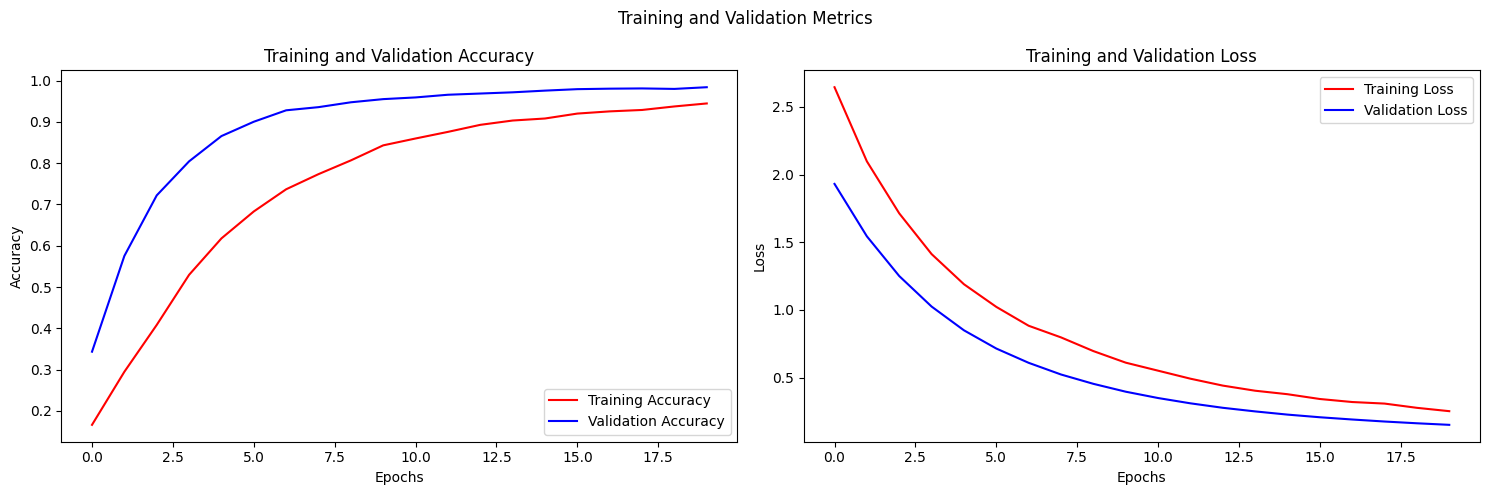

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


# Dapatkan jumlah epoch
epochs = range(len(acc))

# Visualisasi
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Training and Validation Metrics')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend(loc="best")
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(label)
    ax[i].set_title(f'Training and Validation {label}')

plt.tight_layout()
plt.show()


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_size = (224, 224)  # Ganti sesuai dengan input model Anda
batch_size = 32

datagen = ImageDataGenerator(rescale=1.0 / 255)
generator = datagen.flow_from_directory(
    directory="C:/Users/ASUS/Downloads/split_dataset_unique/test",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

# Predict with the model
predictions = model.predict(generator)
predicted_classes = np.argmax(predictions, axis=1)

# Map true labels
true_classes = generator.classes
class_indices = generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}

# Print some results
print(true_classes[10:], predicted_classes[10:])

Found 1674 images belonging to 10 classes.
53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 699ms/step
[0 0 0 ... 9 9 9] [0 0 0 ... 9 9 9]


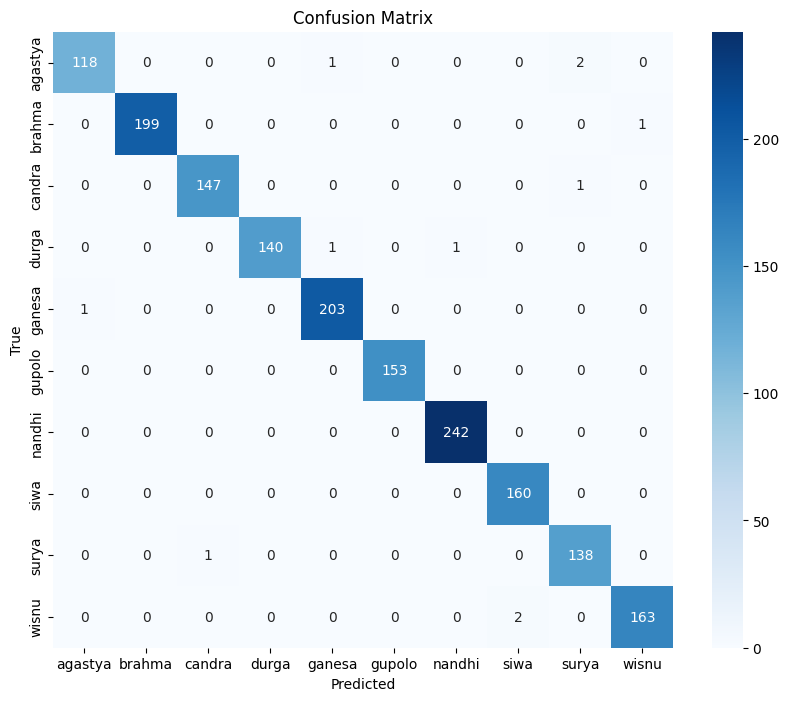

              precision    recall  f1-score   support

     agastya       0.99      0.98      0.98       121
      brahma       1.00      0.99      1.00       200
      candra       0.99      0.99      0.99       148
       durga       1.00      0.99      0.99       142
      ganesa       0.99      1.00      0.99       204
      gupolo       1.00      1.00      1.00       153
      nandhi       1.00      1.00      1.00       242
        siwa       0.99      1.00      0.99       160
       surya       0.98      0.99      0.99       139
       wisnu       0.99      0.99      0.99       165

    accuracy                           0.99      1674
   macro avg       0.99      0.99      0.99      1674
weighted avg       0.99      0.99      0.99      1674



In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_indices.keys(), yticklabels=class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
report = classification_report(true_classes, predicted_classes, target_names=list(class_indices.keys()))
print(report)

#### SAVE THE MODEL

In [21]:
model.save('C:/Users/ASUS/bangkit/ArteFacto_model_57.keras')